## YaEsta.com purchase optimizer

In [155]:
import requests
import bs4
Soup = bs4.BeautifulSoup
import csv
import re
import pandas as pd
import numpy as np
import math
from itertools import combinations

**Importing website HTML data to be parsed**

In [156]:
#To parse local HTML files
with open(r'C:/Users/ignacio.chavarria/Desktop/Scraping/aaa.html', "r") as f:
    content = f.read()

#To parse from web
#response = requests.get("http://dataquestio.github.io/web-scraping-pages/2014_super_bowl.html")
#content = response.content

In [157]:
with open(r"C:\Users\ignacio.chavarria\Desktop\Scraping\YaEsta\drinks.html", encoding="utf8") as f:
    content_d = f.read()
    
with open(r"C:\Users\ignacio.chavarria\Desktop\Scraping\YaEsta\snacks.html", "r", encoding="utf8") as f:
    content_s = f.read()

with open(r"C:\Users\ignacio.chavarria\Desktop\Scraping\YaEsta\chocolates.html", "r", encoding="utf8") as f:
    content_c = f.read()

In [158]:
p_d = Soup(content_d, 'html.parser')
p_s = Soup(content_s, 'html.parser')
p_c = Soup(content_c, 'html.parser')

**Parsing titles and prices:**

In [159]:
parsers = [p_d, p_s, p_c]

In [160]:
def cat_name(n):
    if n == 0:
        return "drink"
    elif n == 1:
        return "snack"
    elif n == 2:
        return "chocolate"

names = []
prices = []
categories = []
ct = 0

for parser in parsers:
    #Get product names
    names_raw = parser.select(".productName")
    for i in names_raw:
        names.append(i.text)

    #Get product prices
    prices_raw = parser.select(".prices")
    for i in prices_raw:
        if len(i) == 3:
            prices.append(float((i.text)[3:]))
        elif len(i) == 5:
            prices.append(float((i.find_all("span")[1].text)[1:]))

    #Get product categories
    cats = [ cat_name(ct) for i in range((len(categories)), len(prices))]
    for i in cats:
        categories.append(i)
    ct += 1

In [161]:
#Create dataframe
df = pd.DataFrame(
    {'name': names[:-9],
     'category': categories,
     'price': prices
    })

In [162]:
def amount(i):
    if re.findall('[ ]([0-9\,\.]+)(?=\s*[mMgG]([ lLrR\.]|\Z)([ \.]|\Z))', i):
        test2 = re.findall('[ ]([0-9\,\.]+)(?=\s*[mMgG]([ lLrR\.]|\Z)([ \.]|\Z))', i)
    else:
        test2 = re.findall('[ ]([0-9\,\.]+)(?=\s*[mMgG]([ lLrR\.]|\Z))', i)

    if test2:
        return float(test2[0][0].replace(",", "."))
    else:
        return math.nan

df['amount'] = df['name'].apply(lambda x: amount(x))

In [163]:
df = df.dropna(subset=['amount']).reset_index(drop=True)

In [164]:
#df['category'].value_counts()

In [165]:
df.shape

(245, 4)

In [166]:
df['amount_per_dollar'] =  df['amount'] / df['price']

In [167]:
df['idx'] = df.index

In [168]:
gc = 5

In [169]:
#df.shape

In [170]:
df = df[df['price'] <= gc]
df.shape

(175, 6)

In [171]:
#df['category'].value_counts()

In [172]:
df_c = df.loc[df['category'] == 'chocolate', :].sort_values('amount_per_dollar', ascending=[False])
df_d = df.loc[df['category'] == 'drink', :].sort_values('amount_per_dollar', ascending=[False])
df_s = df.loc[df['category'] == 'snack', :].sort_values('amount_per_dollar', ascending=[False])
#df_d = df.loc[lambda df: df.category == 'drink', :].sort_values('amount_per_dollar', ascending=[False])
#df_s = df[df['category'] == 'snack'].sort_values('amount_per_dollar', ascending=[False])

In [173]:
df_s1 = df_s.iloc[:10].sort_values('price', ascending=True)
df_d1 = df_d.iloc[:10].sort_values('price', ascending=True)
df_c1 = df_c.iloc[:10].sort_values('price', ascending=True)

In [174]:
dfs = [df_s1, df_d1, df_c1]

#Create dictionary with K values for computing combinations per df
d = {}
for n in range(len(dfs)):
    products = 0
    total = 0
    for i in range(dfs[n].shape[0]):
        if dfs[n].price.iloc[i] <= gc:
            total += dfs[n].price.iloc[i]
            if total >= gc:
                break
            products += 1
        else:
            break
    d[n] = int(products)

In [175]:
#Find top combinations per segment
top = {}

for y in range(len(dfs)):    
    combination_id = {}
    ti, tp, ta = [],[],[]

    for k in range(1, d[y] + 1):
        ti += list(combinations(dfs[y].idx, k))
        tp += list(combinations(dfs[y].price, k))
        ta += list(combinations(dfs[y].amount, k))

    for i in range(len(ti)):
        if sum(tp[i]) <= gc:
            combination_id[i] = []
            combination_id[i].append(list(ti[i]))
            combination_id[i].append(sum(tp[i]))
            combination_id[i].append(sum(ta[i]))

    top[y] = sorted(combination_id.items(), key=lambda x: x[1][2], reverse=True)[0][1:]

In [176]:
top

{0: ([[71, 81], 4.8799999999999999, 500.0],),
 1: ([[42, 15, 14, 16, 2], 4.7200000000000006, 2737.0],),
 2: ([[190], 4.5800000000000001, 250.0],)}

In [177]:
labels = ["'snack'", "'drink'", "'candy'"]

def gr_or_ml(category):
    if category == "'drink'":
        return "Total milliliters:"
    else:
        return "Total grams:"

for i in top:
    print('Basket:', labels[i])
    for x in top[i][0][0]:
        print(" ", df.loc[lambda df: df.idx == x, 'name'].item())
    print('Total cost: $', top[i][0][1])
    print(gr_or_ml(labels[i]), top[i][0][2])
    print("\n")

Basket: 'snack'
  CRIS MANI FAMILIAR 100 G
  CRIS MANI CLÁSICO TARRO 400 G
Total cost: $ 4.88
Total grams: 500.0


Basket: 'drink'
  Sunny Jugo 237 ml. Guayaba
  TONI Té Adelgazante Toronja 500ml.
  TONI Té Energizante Mora 500ml.
  TONI Té Adelgazante Limón 500ml.
  Sunny Jugo 1000 ml. Durazno
Total cost: $ 4.72
Total milliliters: 2737.0


Basket: 'candy'
  Hoja Verde Choco Avellana 250gr
Total cost: $ 4.58
Total grams: 250.0




In [226]:
from sklearn.utils import shuffle

original_dfs = [df_s, df_d, df_c]
results_dict = {}
random_baskets = 100000

for df_no in range(len(original_dfs)):
    random_results = []
    min_price = original_dfs[df_no].sort_values('price', ascending=True)['price'].iloc[0]
    for i in range(random_baskets):
        random_df = shuffle(original_dfs[df_no])#.sample(frac=1)
        random_basket = []
        balance = gc
        amount = 0

        for n in range(random_df.shape[0]):
            if balance - random_df.price.iloc[n] >= 0:
                balance -= random_df.price.iloc[n]
                amount += random_df.amount.iloc[n]
                random_basket.append(random_df.name.iloc[n])
            elif balance < min_price:
                break
            else:
                pass

        random_results.append(amount)
    results_dict[df_no] = random_results

In [230]:
print(max(results_dict[1]))
print(top[1][0][2])
print(len([x for x in results_dict[1] if x >= top[1][0][2]]))

2800.0
2737.0
20


In [231]:
for i in range(len(labels)):
    print("Random", labels[i], "baskets tie or beat the optimized basket", "%.2f%%" % (100 * 
          len([x for x in results_dict[i] if x >= top[i][0][2]]) / random_baskets), "of the time.")

Random 'snack' baskets tie or beat the optimized basket 0.19% of the time.
Random 'drink' baskets tie or beat the optimized basket 0.02% of the time.
Random 'candy' baskets tie or beat the optimized basket 3.07% of the time.


In [232]:
optimized_amount_snack = top[0][0][2]
optimized_amount_drink = top[1][0][2]
optimized_amount_candy = top[2][0][2]

opt_baskets = [optimized_amount_snack, optimized_amount_drink, optimized_amount_candy]

for i in range(len(opt_baskets)):
    print("The optimized", labels[i], "basket is over", 
          math.floor((opt_baskets[i] - np.mean(results_dict[i])) / np.std(results_dict[i])), 
          "standard deviations away from the random basket mean")
    #print(np.mean(results_dict[i]) + (np.std(results_dict[i]) * 3))

The optimized 'snack' basket is over 3 standard deviations away from the random basket mean
The optimized 'drink' basket is over 2 standard deviations away from the random basket mean
The optimized 'candy' basket is over 1 standard deviations away from the random basket mean


In [221]:
print(opt_baskets[0], np.mean(results_dict[0]), np.std(results_dict[0]))

500.0 232.7705 81.0998213916


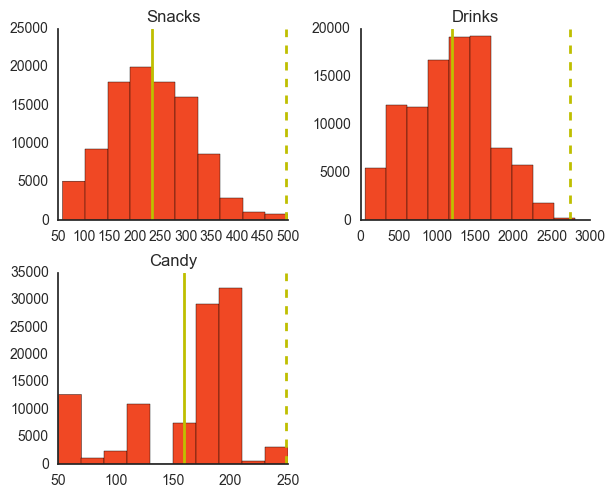

In [237]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 8})

fig, ax = plt.subplots(figsize=(6.2,5))
sns.set_style("white")

plt.subplot(2,2,1)
plt.title('Snacks')
plt.hist(results_dict[0], color='#F04824')
plt.axvline(np.mean(results_dict[0]), color='y', linewidth=2)
plt.axvline(optimized_amount_snack-4, color='y', linestyle='dashed', linewidth=2)
sns.despine(right=True)

plt.subplot(2,2,2)
plt.title('Drinks')
plt.hist(results_dict[1], color='#F04824')
plt.axvline(np.mean(results_dict[1]), color='y', linewidth=2)
plt.axvline(optimized_amount_drink, color='y', linestyle='dashed', linewidth=2)
sns.despine(right=True)

plt.subplot(2,2,3)
plt.title('Candy')
plt.hist(results_dict[2], color='#F04824')
plt.axvline(np.mean(results_dict[2]), color='y', linewidth=2)
plt.axvline(optimized_amount_candy-2, color='y', linestyle='dashed', linewidth=2)
sns.despine(right=True)

plt.tight_layout()
plt.show()

In [239]:
k = 6
drink_items = df.loc[df['category'] == 'drink', 'name']
print("There are", drink_items.shape[0], "total items in the 'drink' category with", 
      (len(list(combinations(drink_items, k)))), "million combinations at k =", k, ".")

There are 43 total items in the 'drink' category with 6096454 million combinations at k = 6 .
